A visualization of our initialization and how the signal contracts or is stable as it is fed forward.

(The notebook's base code based off of a CS231N lecture.)

In [1]:
from __future__ import print_function
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.special

from matplotlib.backends.backend_pdf import PdfPages

In [2]:
act = {'relu': lambda x: np.maximum(0, x),
       'tanh': lambda x: np.tanh(x),
       'elu': lambda x: x * (x > 0) + (np.exp(x) - 1) * (x < 0),
       'gelu': lambda x: x * scipy.special.erfc(-x / np.sqrt(2.))/2
       }

# E[f(z^l)^2]
energy_preserved = {'relu': 0.5, 'elu': 0.645, 'tanh': 0.394, 'srelu': 1., 'lrelu': 0.5, 'gelu': 0.425}

# E[f'(z^(l+1))^2]
back_correction = {'relu': 0.5, 'elu': 0.671, 'tanh': 0.216, 'srelu': 1., 'lrelu': 0.5, 'gelu': 0.4436}

In [5]:
def feed_forward(nonlinearity_name='elu', init_scheme='xavier', p=1.):
    D = np.random.normal(size=(1000, 500), scale=1)
    hidden_layer_sizes = [500] * 15 + [250] * 6
    nonlinearities = [nonlinearity_name]*len(hidden_layer_sizes)

    Hs = {}
    Ms = {}
    Zs = {}

    # forward pass
    for i in range(len(hidden_layer_sizes)):
        X = D if i == 0 else Hs[i-1]    # input at this layer
        fan_in = X.shape[1]
        fan_out = hidden_layer_sizes[i]
        if i == 0:
            if init_scheme == 'xavier':
                W = np.random.uniform(low=-1, high=1, size=(fan_in, fan_out))/np.sqrt((fan_in + fan_out)/6.)
            elif init_scheme == 'he':
                c_forw = 0.5 if nonlinearity_name == 'relu' else 1.
                W = np.random.normal(size=(fan_in, fan_out), scale=1)/np.sqrt(c_forw * fan_in)
            elif init_scheme == 'ours (old)':
                # previous layer is input, so it had an identity transform applied
                W = np.random.normal(size=(fan_in, fan_out), scale=1)/np.sqrt(1.*fan_in)
            elif init_scheme == 'ours (l2)':
                W = np.random.normal(size=(fan_in, fan_out))
                W /= np.linalg.norm(W, axis=0, keepdims=True)

        else:
            if init_scheme == 'xavier':
                W = np.random.uniform(low=-1, high=1, size=(fan_in, fan_out))/np.sqrt((fan_in + fan_out)/6.)
            elif init_scheme == 'he':
                c_forw = 0.5 if nonlinearity_name == 'relu' else 1.
                W = np.random.normal(size=(fan_in, fan_out), scale=1)/np.sqrt(c_forw * fan_in)
            elif init_scheme == 'ours (old)':
                c_forw = energy_preserved[nonlinearity_name]
                W = np.random.normal(size=(fan_in, fan_out), scale=1)/np.sqrt(c_forw*fan_in/p)
            elif init_scheme == 'ours (l2)':
                c_forw = energy_preserved[nonlinearity_name]
                W = np.random.normal(size=(fan_in, fan_out))
                W /= np.linalg.norm(W, axis=0, keepdims=True)
                W /= np.sqrt(c_forw/p)

        H = np.dot(X, W)
        
        
        Z = np.copy(H)
        H = act[nonlinearities[i]](H)/p
        M = np.random.rand(*H.shape) < p
        H *= M  # drop
        Hs[i] = H
        Ms[i] = M
        Zs[i] = Z
    return Zs, Ms, Hs

def plot_mean_and_variance(Zs, Ms, Hs):
    # visualize statistics about the forward pass
    layer_means = [np.mean(H.ravel()) for i,H in Hs.items()]
    layer_stds = [np.std(H.ravel()) for i,H in Hs.items()]

    plt.figure()
    plt.subplot(221)
    plt.plot(list(Hs.keys()), layer_means, 'ob-')
    plt.title('layer mean')
    plt.subplot(222)
    plt.plot(list(Hs.keys()), layer_stds, 'or-')
    plt.title('layer std')

    layer_means = [np.mean(Z.ravel()) for i,Z in Zs.items()]
    layer_stds = [np.std(Z.ravel()) for i,Z in Zs.items()]

    plt.subplot(223)
    plt.plot(list(Zs.keys()), layer_means, 'ob-')
    plt.title('layer mean')
    plt.subplot(224)
    plt.plot(list(Zs.keys()), layer_stds, 'or-')
    plt.title('layer std')
    plt.show()

def plot_activations(Zs, Ms, Hs, show_label=False, label_str='Activation Outputs'):
    for i, H in Hs.items():
        if i % 5 == 0 and i != 0:
            plt.hist(H.ravel()[Ms[i].ravel()], 50, histtype='step', normed=True)
    plt.legend(['Layer 5', 'Layer 10', 'Layer 15', 'Layer 20'])
    if show_label: plt.xlabel(label_str)
    
def plot_hidden_inputs(Zs, Ms, Hs, show_label=False, label_str='Nonlinearity Inputs'):
    for i, Z in Zs.items():
        if i % 5 == 0 and i != 0:
            plt.hist(Z.ravel()[Ms[i].ravel()], 50, histtype='step', normed=True)
    plt.legend(['Layer 5', 'Layer 10', 'Layer 15', 'Layer 20'])
    if show_label: plt.xlabel(label_str)

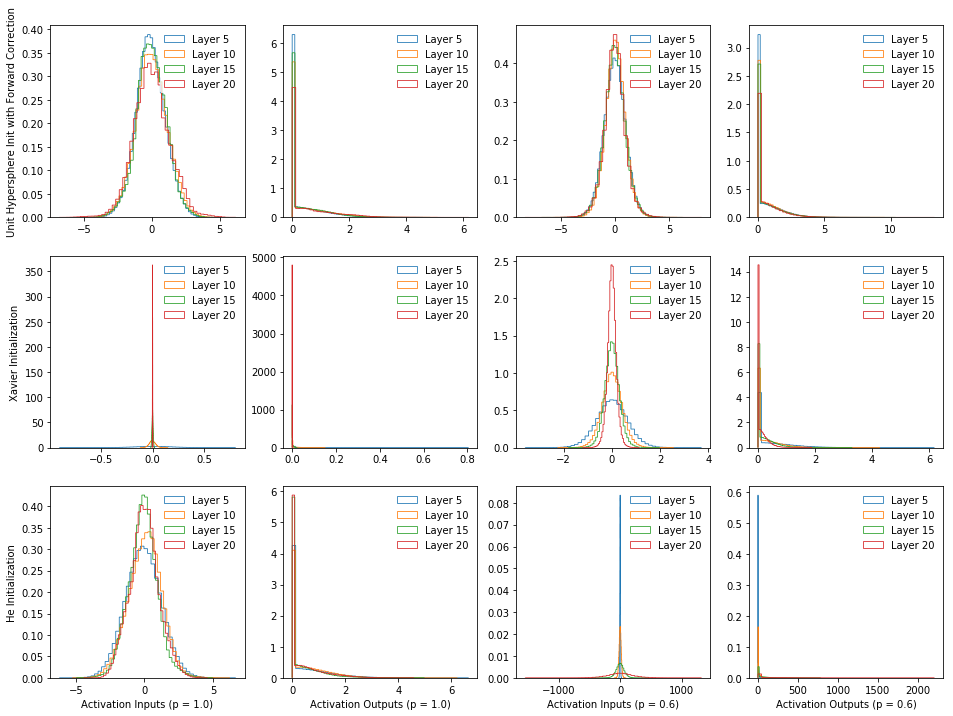

In [6]:
nonlin = 'relu'

with PdfPages('feedforward.pdf') as pdf:
    plt.figure(figsize=(16,12))
    plt.subplot(341)
    plt.ylabel('Unit Hypersphere Init with Forward Correction')
    Zs, Ms, Hs = feed_forward(nonlin, 'ours (l2)', 1.)
    plot_hidden_inputs(Zs, Ms, Hs)
    plt.subplot(342)
    plot_activations(Zs, Ms, Hs)

    plt.subplot(343)
    Zs, Ms, Hs = feed_forward(nonlin, 'ours (l2)', 0.6)
    plot_hidden_inputs(Zs, Ms, Hs)
    plt.subplot(344)
    plot_activations(Zs, Ms, Hs)

    plt.subplot(345)
    plt.ylabel('Xavier Initialization')
    Zs, Ms, Hs = feed_forward(nonlin, 'xavier', 1.)
    plot_hidden_inputs(Zs, Ms, Hs)
    plt.subplot(346)
    plot_activations(Zs, Ms, Hs)

    plt.subplot(347)
    Zs, Ms, Hs = feed_forward(nonlin, 'xavier', 0.6)
    plot_hidden_inputs(Zs, Ms, Hs)
    plt.subplot(348)
    plot_activations(Zs, Ms, Hs)

    plt.subplot(349)
    plt.ylabel('He Initialization')
    Zs, Ms, Hs = feed_forward(nonlin, 'he', 1.)
    plot_hidden_inputs(Zs, Ms, Hs, True, 'Activation Inputs (p = 1.0)')
    plt.subplot(3,4,10)
    plot_activations(Zs, Ms, Hs, True, 'Activation Outputs (p = 1.0)')

    plt.subplot(3,4,11)
    Zs, Ms, Hs = feed_forward(nonlin, 'he', 0.6)
    plot_hidden_inputs(Zs, Ms, Hs, True, 'Activation Inputs (p = 0.6)')
    plt.subplot(3,4,12)
    plot_activations(Zs, Ms, Hs, True, 'Activation Outputs (p = 0.6)')

#     plt.subplots_adjust(left=0.15, right=0.85, top=0.85, bottom=0.15)
    pdf.savefig(bbox_inches='tight')
    plt.show()
    plt.close()


We now visualize the backprop term. Here, our initialization is including only the backprop term. You're then seeing not our init but what our init would be if we only cared for backprop signal.

In [109]:
def feed_back(Zs, Ms, Hs, nonlinearity_name='elu', init_scheme='xavier', p=1.):
    D_back = np.random.normal(size=(1000, 250), scale=0.01)
    hidden_layer_sizes_back = [500] * 15 + [250] * 6
    nonlinearities_back = [nonlinearity_name]*len(hidden_layer_sizes_back)

    Hs_back = {}
    Ms_back = {}
    Zs_back = {}
    back_signal = []
    for i in range(len(hidden_layer_sizes_back)):
        X_back = D_back if i == 0 else Zs_back[i-1]    # input at this layer
        # note that fan_in is fan_out in the forward pass
        fan_in = X_back.shape[1]
        fan_out = hidden_layer_sizes_back[len(nonlinearities_back) - 1 - i]
        if i == 0:
            if init_scheme == 'xavier':
                W_back = np.random.uniform(low=-1, high=1, size=(fan_in, fan_out))/np.sqrt((fan_in + fan_out)/6.)
            elif init_scheme == 'he':
                c_forw = 0.5 if nonlinearity_name == 'relu' else 1.
                W_back = np.random.normal(size=(fan_in, fan_out), scale=1)/np.sqrt(c_forw * fan_out)
            elif init_scheme == 'ours (old)':
                # previous layer is input, so it had an identity transform applied
                W_back = np.random.normal(size=(fan_in, fan_out), scale=1)/np.sqrt(1.*fan_in)
            elif init_scheme == 'ours (l2)':
                W_back = np.random.normal(size=(fan_in, fan_out), scale=1)
                W_back /= np.linalg.norm(W_back, axis=0, keepdims=True)
        else:
            if init_scheme == 'xavier':
                W_back = np.random.uniform(low=-1, high=1, size=(fan_in, fan_out))/np.sqrt((fan_in + fan_out)/6.)
            elif init_scheme == 'he':
                c_forw = 0.5 if nonlinearity_name == 'relu' else 1.
                W_back = np.random.normal(size=(fan_in, fan_out), scale=1)/np.sqrt(c_forw * fan_out)
            elif init_scheme == 'ours (old)':
                c_back = back_correction[nonlinearity_name]
                W_back = np.random.normal(size=(fan_in, fan_out), scale=1)/np.sqrt(c_back*fan_in*p)
            elif init_scheme == 'ours (l2)':
                c_back = back_correction[nonlinearity_name]
                W_back = np.random.normal(size=(fan_in, fan_out), scale=1)
                W_back /= np.linalg.norm(W_back, axis=0, keepdims=True)
                W_back /= np.sqrt(c_back*p)
            else:
                raise Exception("no valid init scheme")

        H_back = np.dot(X_back, W_back)
        if nonlinearity_name == 'tanh':
            deriv = np.mean((1 - (np.tanh(Zs[len(nonlinearities_back) - 1 - i]))**2)**2)
        elif nonlinearity_name == 'elu':
            neg_indices = Zs[len(nonlinearities_back) - 1 - i] < 0
            deriv = (Zs[len(nonlinearities_back) - 1 - i] > 0) + (np.exp(Zs[len(nonlinearities_back) - 1 - i]) * neg_indices)
        elif nonlinearity_name == 'relu':
            neg_indices = Zs[len(nonlinearities_back) - 1 - i] < 0
            deriv = (Zs[len(nonlinearities_back) - 1 - i] > 0)
        elif nonlinearity_name == 'gelu':
            x = Zs[len(nonlinearities_back) - 1 - i]
            deriv = scipy.special.erfc(-x / np.sqrt(2.))/2.
            deriv += x * np.exp(-(x ** 2) / 2.) / np.sqrt(2*np.pi)
        else:
            raise Exception("no valid nonlinearity name")

        Z_back = H_back * deriv
    #     print('Backprop adjustment estimate:', np.mean(deriv**2))
        back_signal.append(np.mean(deriv**2))


        M_back = Ms[20-i]
        Z_back *= M_back  # drop
        Hs_back[i] = H_back
        Ms_back[i] = M_back
        Zs_back[i] = Z_back

    return Zs_back, Ms_back, Hs_back

def plot_back_stats(Zs_back, Ms_back, Hs_back):
    print('mean back signal', np.mean(back_signal))
    layer_means = [np.median(H_back.ravel()[Ms_back[i].ravel()]) for i,H_back in Hs_back.items()]
    layer_stds = [np.std(H_back.ravel()[Ms_back[i].ravel()]) for i,H_back in Hs_back.items()]
    # for i,H_back in Hs.items():
    #     print('hidden layer %d had mean %f and std %f' % (i+1, layer_means[i], layer_stds[i]))
    plt.figure()
    plt.subplot(121)
    plt.plot(list(Hs_back.keys()), layer_means, 'ob-')
    plt.title('layer mean')
    plt.subplot(122)
    plt.plot(list(Hs_back.keys()), layer_stds, 'or-')
    plt.title('layer std')
    plt.show()


def plot_back_pass(Zs_back, Ms_back, Hs_back):
    for i, H_back in Hs_back.items():
        if i % 5 == 0 and i > 0:
            plt.hist(H_back.ravel()[Ms_back[i].ravel()], 30,histtype='step', normed=True)
    plt.legend(['Layer 5', 'Layer 10', 'Layer 15', 'Layer 20'])


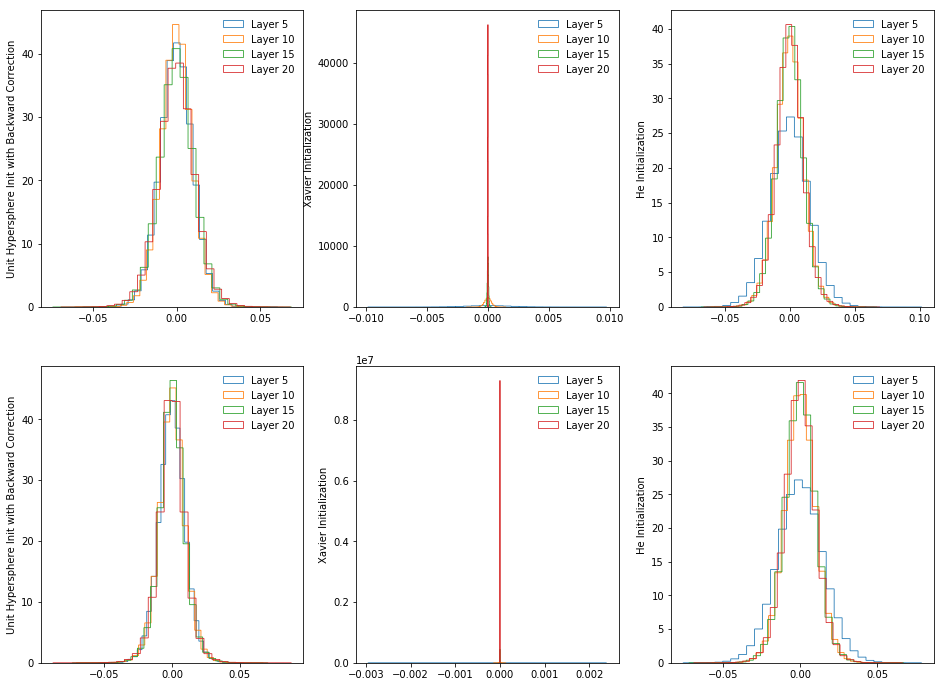

In [110]:
nonlin = 'relu'

with PdfPages('toss.pdf') as pdf:
    plt.figure(figsize=(16,12))
    
    plt.subplot(231)
    plt.ylabel('Unit Hypersphere Init with Backward Correction')
    Zs, Ms, Hs = feed_forward(nonlin, 'ours (l2)', 1.)
    Zs_back, Ms_back, Hs_back = feed_back(Zs, Ms, Hs, nonlin, 'ours (l2)', 1.)
    plot_back_pass(Zs_back, Ms_back, Hs_back)

    plt.subplot(232)
    plt.ylabel('Xavier Initialization')
    Zs, Ms, Hs = feed_forward(nonlin, 'xavier', 1.)
    Zs_back, Ms_back, Hs_back = feed_back(Zs, Ms, Hs, nonlin, 'xavier', 1.)
    plot_back_pass(Zs_back, Ms_back, Hs_back)
    
    plt.subplot(233)
    plt.ylabel('He Initialization')
    Zs, Ms, Hs = feed_forward(nonlin, 'he', 1.)
    Zs_back, Ms_back, Hs_back = feed_back(Zs, Ms, Hs, nonlin, 'he', 1.)
    plot_back_pass(Zs_back, Ms_back, Hs_back)
    
    plt.subplot(234)
    plt.ylabel('Unit Hypersphere Init with Backward Correction')
    Zs, Ms, Hs = feed_forward(nonlin, 'ours (l2)', 0.6)
    Zs_back, Ms_back, Hs_back = feed_back(Zs, Ms, Hs, nonlin, 'ours (l2)', 0.6)
    plot_back_pass(Zs_back, Ms_back, Hs_back)

    plt.subplot(235)
    plt.ylabel('Xavier Initialization')
    Zs, Ms, Hs = feed_forward(nonlin, 'xavier', 0.6)
    Zs_back, Ms_back, Hs_back = feed_back(Zs, Ms, Hs, nonlin, 'xavier', 0.6)
    plot_back_pass(Zs_back, Ms_back, Hs_back)
    
    plt.subplot(236)
    plt.ylabel('He Initialization')
    Zs, Ms, Hs = feed_forward(nonlin, 'he', 1.)
    Zs_back, Ms_back, Hs_back = feed_back(Zs, Ms, Hs, nonlin, 'he', 0.6)
    plot_back_pass(Zs_back, Ms_back, Hs_back)

#     plt.subplots_adjust(left=0.15, right=0.85, top=0.85, bottom=0.15)
    pdf.savefig(bbox_inches='tight')
    plt.show()
    plt.close()

Here is how we found our forward corrective factors:

In [6]:
Xs = np.random.normal(size=1000000, scale=1)

print('Corrective factors:')

relu_out = Xs * (Xs > 0)
print('ReLU:', np.mean(relu_out**2)/np.var(Xs))

elu_out = Xs * (Xs > 0) + (np.exp(Xs) - 1) * (Xs <= 0)
print('ELU:', np.mean(elu_out**2)/np.var(Xs))

srelu_out = Xs * (Xs > -3)
print('SReLU:', np.mean(srelu_out**2)/np.var(Xs))

tanh_out = np.tanh(Xs)
print('tanh:', np.mean(tanh_out**2)/np.var(Xs))

lrelu_out = Xs * (Xs > 0) + 0.01 * Xs * (Xs <= 0)
print('LReLU:', np.mean(lrelu_out**2)/np.var(Xs))

gelu_out = Xs * scipy.special.erfc(-Xs/np.sqrt(2.))/2.
print('GELU:', np.mean(gelu_out**2)/np.var(Xs))

Corrective factors:
ReLU: 0.498663100361
ELU: 0.643745150166
SReLU: 0.985463140218
tanh: 0.393788674023
LReLU: 0.498713234299
GELU: 0.424182740513
